# Darts API Tutorial

This notebook explores the Darts library API for time series forecasting.

- **Reference Documentation:** [darts.API.md](darts.API.md)
- **API Script:** [darts.API.py](darts.API.py)

**Citations:**
- Darts Library: https://unit8co.github.io/darts/
- Herzen et al. (2022). "Darts: User-Friendly Modern Machine Learning for Time Series" JMLR 23(124):1−6

**Notebook Flow:**
1. Setup and Imports
2. TimeSeries Creation
3. Data Preprocessing
4. Statistical Models
5. Deep Learning Models
6. Model Evaluation


## Imports


In [5]:
import logging
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Darts core imports.
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.statistics import check_seasonality
from darts.metrics import mape, rmse, mae, smape
from darts.utils.utils import ModelMode


# Darts models.
from darts.models import (
    Prophet,
    NBEATSModel,
    RNNModel,
    ExponentialSmoothing,
    NaiveSeasonal
)

# Configure logging.
logging.basicConfig(level=logging.INFO)
_LOG = logging.getLogger(__name__)

# Set plotting style.
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

# Set random seed for reproducibility.
np.random.seed(42)

print("All imports successful!")


All imports successful!


## Load Sample Data

Load the PJME hourly energy consumption dataset for demonstration.


In [6]:
# Load the energy consumption data.
data_path = 'PJME_hourly.csv'
df = pd.read_csv(data_path)

# Parse datetime and set as index
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')
df = df.sort_index()

# Rename column for clarity
df = df.rename(columns={'PJME_MW': 'energy_consumption'})

print(f"\nDate Range: {df.index.min()} to {df.index.max()}")
print(f"Total Hours: {len(df):,}")
print(f"Missing Values: {df.isnull().sum().sum()}")

df.head()



Date Range: 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Total Hours: 145,366
Missing Values: 0


,energy_consumption
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


In [7]:
# Check for missing timestamps and fill if necessary
date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
missing_dates = date_range.difference(df.index)
df = df[~df.index.duplicated(keep='first')]
print(f"Missing timestamps: {len(missing_dates)}")

if len(missing_dates) > 0:
    print("Filling missing timestamps with interpolation...")
    df = df.reindex(date_range)
    df = df.interpolate(method='time')
    print("Missing values filled!")

# Display statistics
df.describe()


Missing timestamps: 30
Filling missing timestamps with interpolation...
Missing values filled!


,energy_consumption
count,145392.000000
mean,32078.930711
std,6464.279302
min,14544.000000
25%,27571.000000
50%,31420.000000
75%,35647.000000
max,62009.000000


## TimeSeries Creation

The `TimeSeries` class is the fundamental data structure in Darts.


In [8]:
# Create Darts TimeSeries object
series = TimeSeries.from_dataframe(
    df.reset_index(),
    time_col='index',
    value_cols='energy_consumption',
    freq='H'
)

print(f"TimeSeries created!")
print(f"Series length: {len(series)}")
print(f"Start: {series.start_time()}")
print(f"End: {series.end_time()}")
print(f"⏱Frequency: {series.freq}")


TimeSeries created!
Series length: 145392
Start: 2002-01-01 01:00:00
End: 2018-08-03 00:00:00
⏱Frequency: <Hour>


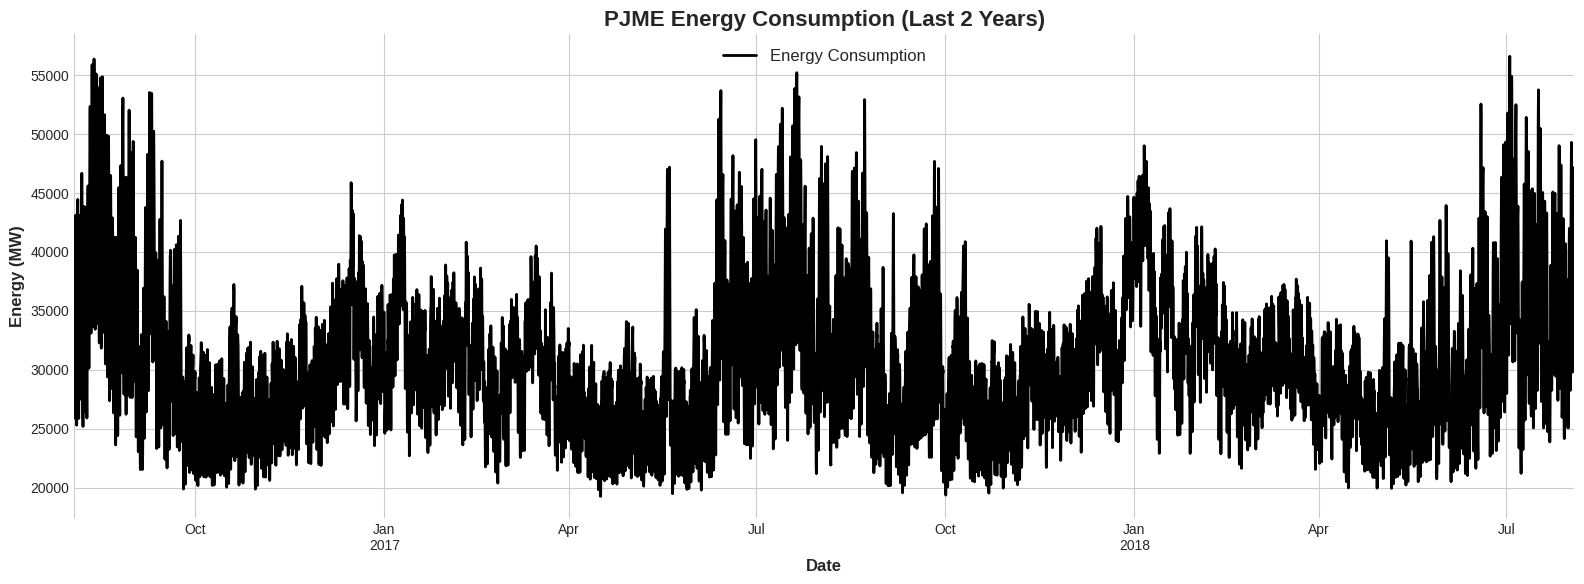

In [9]:
# TimeSeries operations: slicing, indexing.
# Use last 2 years for demonstration.
series_subset = series[-24*365*2:]

# Plot the time series.
fig, ax = plt.subplots(figsize=(16, 6))
series_subset.plot(ax=ax, label='Energy Consumption')
ax.set_title('PJME Energy Consumption (Last 2 Years)', fontsize=16, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Energy (MW)')
ax.legend()
plt.tight_layout()
plt.show()


## Data Preprocessing

### Scaling Data

Neural network models require scaled data for optimal training.


In [10]:
# Train/Test split.
TEST_SIZE = 24 * 30  # 30 days for testing.
train = series_subset[:-TEST_SIZE]
test = series_subset[-TEST_SIZE:]

print(f"Training size: {len(train)} hours ({len(train)/24:.0f} days)")
print(f"Test size: {len(test)} hours ({len(test)/24:.0f} days)")


Training size: 16800 hours (700 days)
Test size: 720 hours (30 days)


In [11]:
# Scale the data using StandardScaler.
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

print("Data scaled for neural network models!")
print(f"Scaled train range: [{train_scaled.min().values()[0][0]:.2f}, {train_scaled.max().values()[0][0]:.2f}]")


Data scaled for neural network models!
Scaled train range: [0.27, 0.27]


### Seasonality Detection

Darts provides statistical tests to detect seasonal patterns.


In [12]:
# Check for daily and weekly seasonality.
print("Seasonality Analysis:")
print("-" * 50)

is_daily, _ = check_seasonality(series_subset, m=24, max_lag=48)
print(f"Daily (24h) seasonality detected: {is_daily}")

is_weekly, _ = check_seasonality(series_subset, m=168, max_lag=336)
print(f"Weekly (168h) seasonality detected: {is_weekly}")


Seasonality Analysis:
--------------------------------------------------
Daily (24h) seasonality detected: True
Weekly (168h) seasonality detected: True


## Statistical Models

### Naive Seasonal Model

Simple baseline that repeats the last observed seasonal pattern.


In [13]:
# Naive Seasonal with weekly seasonality.
naive_model = NaiveSeasonal(K=168)
naive_model.fit(train)
naive_pred = naive_model.predict(len(test))

# Evaluate.
naive_mape = mape(test, naive_pred)
print(f"Naive Seasonal MAPE: {naive_mape:.2f}%")


Naive Seasonal MAPE: 17.59%


### Exponential Smoothing

Classical time series model with trend and seasonality components.


In [14]:
# Exponential Smoothing with daily seasonality.
exp_model = ExponentialSmoothing(
    seasonal_periods=24,
    trend=None,
    seasonal=ModelMode.ADDITIVE
)
exp_model.fit(train)
exp_pred = exp_model.predict(len(test))

# Evaluate.
exp_mape = mape(test, exp_pred)
print(f"Exponential Smoothing MAPE: {exp_mape:.2f}%")


Exponential Smoothing MAPE: 21.79%


### Prophet Model

Facebook's additive forecasting model with automatic seasonality detection.


In [15]:
# Prophet with multiple seasonalities.
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    seasonality_mode='multiplicative'
)
prophet_model.fit(train)
prophet_pred = prophet_model.predict(len(test))

# Evaluate.
prophet_mape = mape(test, prophet_pred)
print(f"Prophet MAPE: {prophet_mape:.2f}%")


Prophet MAPE: 12.21%


## Deep Learning Models

### N-BEATS Model

Neural Basis Expansion Analysis for interpretable time series forecasting.


In [16]:
# N-BEATS model configuration.
nbeats_model = NBEATSModel(
    input_chunk_length=168,   # 1 week lookback.
    output_chunk_length=24,   # 1 day forecast.
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=256,
    n_epochs=80,
    batch_size=1024,
    random_state=42,
    pl_trainer_kwargs={
        "enable_progress_bar": True,
        "accelerator": "auto",
    }
)

# Train on scaled data.
nbeats_model.fit(train_scaled, verbose=True)

# Predict and inverse transform.
nbeats_pred_scaled = nbeats_model.predict(len(test))
nbeats_pred = scaler.inverse_transform(nbeats_pred_scaled)

# Evaluate.
nbeats_mape = mape(test, nbeats_pred)
print(f"N-BEATS MAPE: {nbeats_mape:.2f}%")


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0   

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=80` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

N-BEATS MAPE: 9.71%


### LSTM Model

Long Short-Term Memory recurrent neural network.


In [17]:
# LSTM model configuration.
lstm_model = RNNModel(
    model='LSTM',
    input_chunk_length=168,
    output_chunk_length=24,
    training_length=192,
    hidden_dim=64,
    n_rnn_layers=2,
    dropout=0.1,
    batch_size=1024,
    n_epochs=50,
    random_state=42,
    pl_trainer_kwargs={
        "enable_progress_bar": True,
        "accelerator": "auto",
    }
)

# Train on scaled data.
lstm_model.fit(train_scaled, verbose=True)

# Predict and inverse transform.
lstm_pred_scaled = lstm_model.predict(len(test))
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)

# Evaluate.
lstm_mape = mape(test, lstm_pred)
print(f"LSTM MAPE: {lstm_mape:.2f}%")


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 50.4 K | train
6 | V               | Linear           | 65     | train
-------------------------------------------------------------
50.5 K    Trainable params
0         Non-trainable p

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LSTM MAPE: 29.42%


## Model Evaluation and Comparison

Compare all models using multiple metrics.


In [18]:
# Collect all predictions.
predictions = {
    'Naive Seasonal': naive_pred,
    'Exponential Smoothing': exp_pred,
    'Prophet': prophet_pred,
    'N-BEATS': nbeats_pred,
    'LSTM': lstm_pred
}

# Calculate metrics for all models.
results = []
for name, pred in predictions.items():
    results.append({
        'Model': name,
        'MAPE (%)': round(mape(test, pred), 2),
        'RMSE (MW)': int(round(rmse(test, pred))),
        'MAE (MW)': int(round(mae(test, pred))),
        'SMAPE (%)': round(smape(test, pred), 2)
    })

# Create comparison DataFrame.
results_df = pd.DataFrame(results).sort_values('MAPE (%)')
print("MODEL COMPARISON")
print("-" * 60)
print(results_df.to_string(index=False))
print(f"\nBest Model: {results_df.iloc[0]['Model']}")


MODEL COMPARISON
------------------------------------------------------------
                Model  MAPE (%)  RMSE (MW)  MAE (MW)  SMAPE (%)
              N-BEATS      9.71       4303      3531      10.00
              Prophet     12.21       4887      3973      11.14
       Naive Seasonal     17.59       7517      6193      16.29
Exponential Smoothing     21.79       8381      7250      18.90
                 LSTM     29.42      11138      9325      24.05

Best Model: N-BEATS


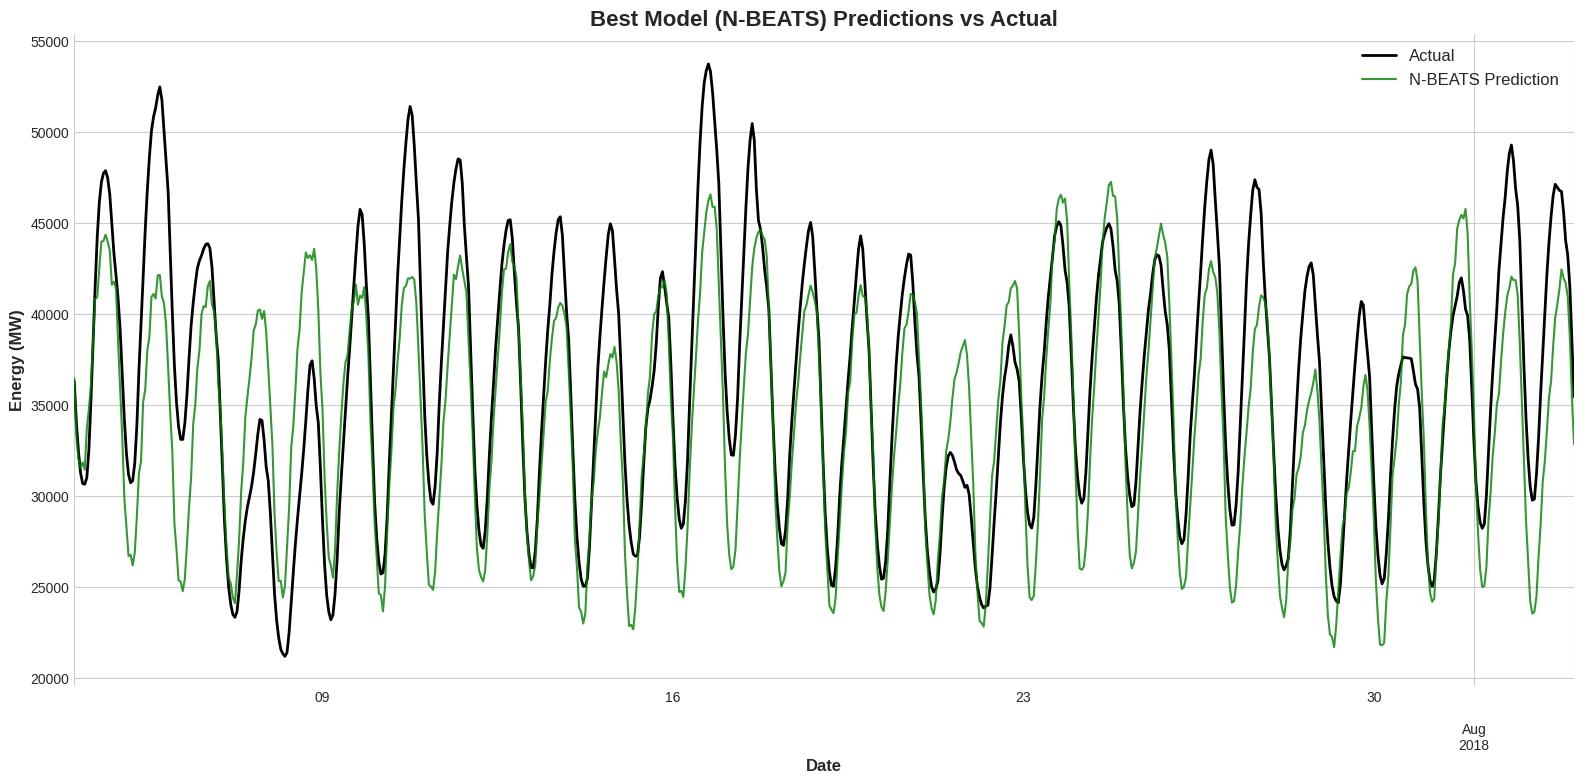

In [19]:
# Visualize predictions vs actual.
fig, ax = plt.subplots(figsize=(16, 8))

# Plot actual.
test.plot(ax=ax, label='Actual', color='black', linewidth=2)

# Plot best predictions.
best_model = results_df.iloc[0]['Model']
predictions[best_model].plot(ax=ax, label=f'{best_model} Prediction',
                             color='green', linewidth=1.5, alpha=0.8)

ax.set_title(f'Best Model ({best_model}) Predictions vs Actual',
             fontsize=16, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Energy (MW)')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()
